In [1]:
# standart libs
import sys
import random
import copy
import cProfile


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

# executable
print(sys.executable)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/home/namur/coding/notebooks/env/bin/python3


# Init the model and load data

In [2]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [3]:
# meta
geo_model_extent_1 = [0,1000,0,1000,0,1000]
section_1 = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df_1 = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df_1.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df_1.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df_1 = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df_1.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df_1.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df_1.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

# geoData
surface_points_input_data_1 = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data_1 = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df_1 = surface_points_input_data_1[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df_1.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df_1['param1'] = 10

# Orientaions
orientations_original_df_1 = orientaions_input_data_1[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

# Setup pass data to the model and compute

In [4]:
# %%timeit
# setup model 1
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()
Run realizations setup checks until stable workflow.


In [5]:
cProfile.run(
    gp.compute_model(model=geo_model, sort_surfaces=False)
)

         2 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




TypeError: exec() arg 1 must be a string, bytes or code object

# Get boolen matrix of section with points marking transition  & plot

In [ ]:
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

In [ ]:
# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

In [ ]:
# plot original data
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-2']['zvals'], '.')
plt.plot(
    surface_points_original_df_1[surface_points_original_df_1.surface == 'rock1']['X'],
    surface_points_original_df_1[surface_points_original_df_1.surface == 'rock1']['Z'],
    'o'
)
plt.show()

# Generate new line without nugget effect

## Generate artifical line
- noise is > 10%
- no nugget effect

In [ ]:
# Pass origin data to mode
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

In [ ]:
# get interpolated tops and extract one
x = tops_dict['0-1']['xvals']
y = tops_dict['0-1']['yvasl']
z = tops_dict['0-1']['zvals']

# add noise to the top
noise = np.random.normal(0,5,len(x))
xx = x + noise
noise = np.random.normal(0,5,len(y))
yy = y + noise
yy = np.array(y)
noise = np.random.normal(0,5,len(z))
zz = z + noise

# remove points that are out of bound
xx[xx < 0], xx[xx > 1000] = 0, 1000
yy[yy < 0], yy[yy > 1000] = 0, 1000
zz[zz < 0], zz[zz > 1000] = 0, 1000

In [ ]:
# plot
plt.plot(xx[::4],zz[::4], '.', color='steelblue')
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-2']['zvals'], '.')
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    'o',
    color='black'
)
plt.grid()

# Compute the model again with new line input (noisy top) but no filter or increased nugget effect

In [ ]:
# creat new df including new noise data
df0 = surface_points_original_df_1
df1 = pd.DataFrame(columns=df0.columns)
df1.X = xx[::4]
df1.Y = yy[::4]
df1.Z = zz[::4]
df1.surface = 'rock1'
df1.param1 = 10

# concate into new df
df2 = pd.concat([df0, df1], ignore_index=True)

# set new surface points
geo_model.set_surface_points(df2, update_surfaces=False)
geo_model.update_to_interpolator()

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

In [ ]:
# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

In [ ]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

# Compute the model again with new line input (noisy top), increased nugget effect for new points but no filter

## Recreat original model and compute

In [ ]:
# Pass origin data to mode
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

In [6]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'])
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

NameError: name 'tops_dict' is not defined

## New set with noise and but higher nugget effect for new data

In [7]:
# creat new df including new noise data
df0 = surface_points_original_df_1
df1 = pd.DataFrame(columns=df0.columns)
df1.X = xx[::4]
df1.Y = yy[::4]
df1.Z = zz[::4]
df1.surface = 'rock1'
df1.param1 = 10

# concate into new df
df2 = pd.concat([df0, df1], ignore_index=True)

# set new input again (form df2)
geo_model.set_surface_points(df2, update_surfaces=False)

# we know that df2 is a concentation of the surface_points df and the line df.
# hence the indices of the line are the ones
rang_idx = pd.RangeIndex(start=len(df0.index), stop=len(df2.index), step=1)
geo_model.modify_surface_points(rang_idx, smooth=1)
geo_model.update_to_interpolator()

# print(geo_model.surface_points)

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

NameError: name 'xx' is not defined

In [8]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

NameError: name 'tops_dict' is not defined

# Recreate olriginal state

In [9]:
# Pass origin data to mode
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


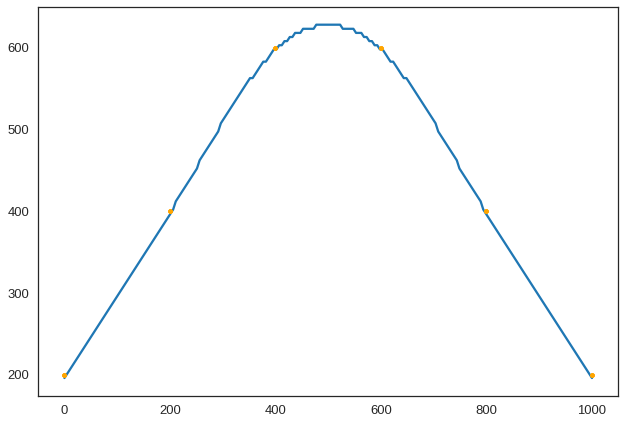

In [10]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'])
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

# Create model with noise, heigh nugget effect and filter 

In [11]:
# now we remove points that are close to measurements
# rember y is not important for now so we can focus on x
# however we need to filter the x values with the right y vals
bok = np.ones(xx.shape)
sps = surface_points_original_df_1
t = 40

for index, row in sps.iterrows():
    
    # loop over point of measurements and mark points that are close
    x = row['X']
    # y = row['Y']  # as here all points have the same y value in the section
    z = row['Z']
    
    xlow, xheigh = (x - t), x + t
    bx = np.where((xx > xlow) & (xx < xheigh))
    bok[bx] = 0
    
    # ylow, yheigh = (y - t), y + t
    # bx = np.where((yy > ylow) & (yy < yheigh))
    # bok[bx] = 0
    
    zlow, zheigh = (z - t), z + t
    bx = np.where((zz > zlow) & (zz < zheigh))
    bok[bx] = 0
    
# make a boolen out of it
Bok = bok == 1

NameError: name 'xx' is not defined

In [12]:
# plot
plt.plot(xx[Bok][::4],zz[Bok][::4], '.', color='steelblue')
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    'o',
    color='orange'
)
plt.grid()

NameError: name 'xx' is not defined

In [13]:
# creat new df including new noise data
df0 = surface_points_original_df_1
df1 = pd.DataFrame(columns=df0.columns)
df1.X = xx[Bok][::4]
df1.Y = yy[Bok][::4]
df1.Z = zz[Bok][::4]
df1.surface = 'rock1'
df1.param1 = 10

# concate into new df
df2 = pd.concat([df0, df1], ignore_index=True)

# set new input again (form df2)
geo_model.set_surface_points(df2, update_surfaces=False)

# we know that df2 is a concentation of the surface_points df and the line df.
# hence the indices of the line are the ones
rang_idx = pd.RangeIndex(start=len(df0.index), stop=len(df2.index), step=1)
geo_model.modify_surface_points(rang_idx, smooth=100)
geo_model.update_to_interpolator()

# print(geo_model.surface_points)

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

NameError: name 'xx' is not defined

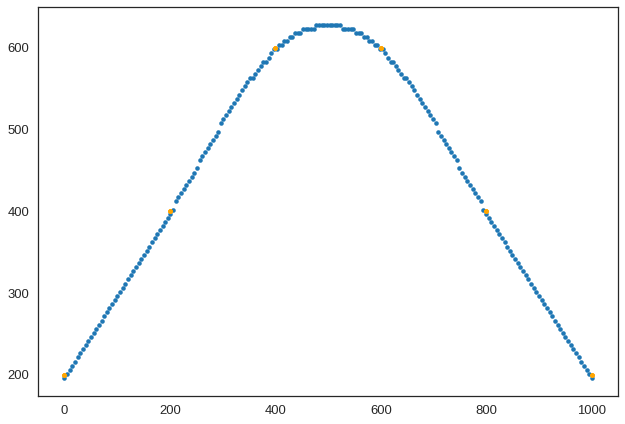

In [14]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

# Recreate olriginal state

In [15]:
# Pass origin data to mode
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


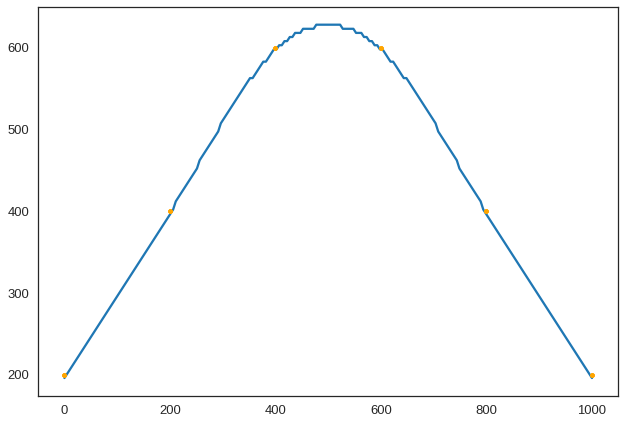

In [16]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'])
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

# Filter but no low nugget effect

In [17]:
# now we remove points that are close to measurements
# rember y is not important for now so we can focus on x
# however we need to filter the x values with the right y vals
bok = np.ones(xx.shape)
sps = surface_points_original_df_1
t = 40

for index, row in sps.iterrows():
    
    # loop over point of measurements and mark points that are close
    x = row['X']
    # y = row['Y']  # as here all points have the same y value in the section
    z = row['Z']
    
    xlow, xheigh = (x - t), x + t
    bx = np.where((xx > xlow) & (xx < xheigh))
    bok[bx] = 0
    
    # ylow, yheigh = (y - t), y + t
    # bx = np.where((yy > ylow) & (yy < yheigh))
    # bok[bx] = 0
    
    zlow, zheigh = (z - t), z + t
    bx = np.where((zz > zlow) & (zz < zheigh))
    bok[bx] = 0
    
# make a boolen out of it
Bok = bok == 1

NameError: name 'xx' is not defined

In [18]:
# creat new df including new noise data
df0 = surface_points_original_df_1
df1 = pd.DataFrame(columns=df0.columns)
df1.X = xx[Bok][::4]
df1.Y = yy[Bok][::4]
df1.Z = zz[Bok][::4]
df1.surface = 'rock1'
df1.param1 = 10

# concate into new df
df2 = pd.concat([df0, df1], ignore_index=True)

# set new input again (form df2)
geo_model.set_surface_points(df2, update_surfaces=False)
geo_model.update_to_interpolator()

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

NameError: name 'xx' is not defined

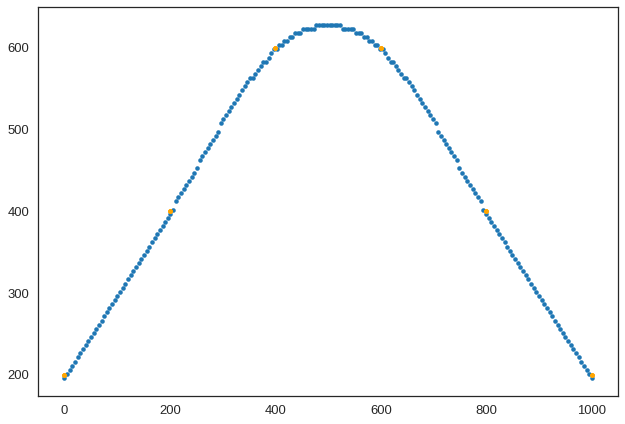

In [19]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

# Filter and take every nth point 

In [20]:
# Pass origin data to mode
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


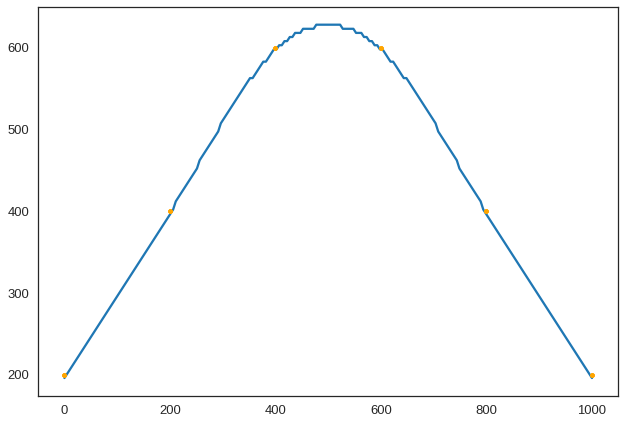

In [21]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'])
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


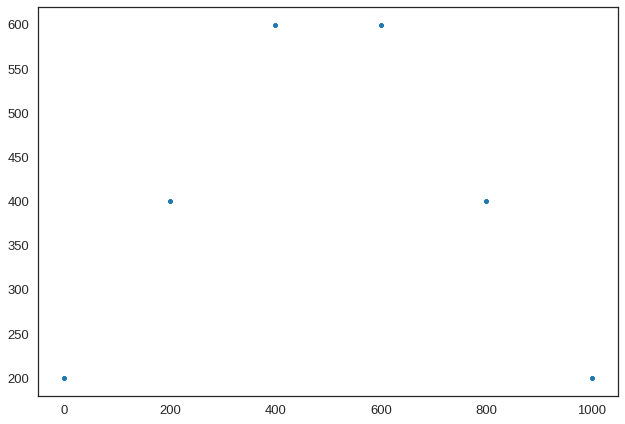

NameError: name 'Bok' is not defined

In [22]:
# Pass origin data to mode
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)


plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.'
)
plt.show()


# get interpolated tops and extract one
x = tops_dict['0-1']['xvals']
y = tops_dict['0-1']['yvasl']
z = tops_dict['0-1']['zvals']

# add noise to the top
noise = np.random.normal(0,5,len(x))
xx = np.array(x) # + noise
noise = np.random.normal(0,5,len(y))
yy = np.array(y) #+ noise
yy = np.array(y)
noise = np.random.normal(0,5,len(z))
zz = np.array(z) # + noise

# remove points that are out of bound
xx[xx < 0], xx[xx > 1000] = 0, 1000
yy[yy < 0], yy[yy > 1000] = 0, 1000
zz[zz < 0], zz[zz > 1000] = 0, 1000



# creat new df including new noise data
df0 = surface_points_original_df_1
df1 = pd.DataFrame(columns=df0.columns)
df1.X = xx[Bok][::10]
df1.Y = yy[Bok][::10]
df1.Z = zz[Bok][::10]
df1.surface = 'rock1'
df1.param1 = 10

# concate into new df
df2 = pd.concat([df0, df1], ignore_index=True)

# set new input again (form df2)
geo_model.set_surface_points(df2, update_surfaces=False)
geo_model.update_to_interpolator()

plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.'
)

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

## Notes
- When lines comest to close to measurements and the a potential lower lines has point over a higher line artifacts get introduced into the model.
To reconstruct: change height of max zvals, y value and/or increase noise 
- by to strong variation within close distance the model collapses as well # take less points

# Question
1. What defines the nugget effect?
2. What are the constrains regarding points close to each other?
3. How to deal with noise?
4. Why the wired shape?
5. Naming of scalar field or how does it relate to surfaces

In [ ]:
# You can not have 1000 points in one section and only 8 in all others .... # Overfitting
# 

In [ ]:
geo_model.solutions.scalar_field_at_surface_points  # s-field of 1st surface # 2nd surface

In [ ]:
gp.plot_2d(geo_model)

In [ ]:
gp.plot.plot_section(geo_model, 3, )